# 第5章: 係り受け解析

In [1]:
import re
import CaboCha

In [2]:
cabocha = CaboCha.Parser()
space_pattern = re.compile(r'\u3000')
chapter_pattern = re.compile(r'([\n|\r\n|\r]|(?<=^))([一二三四五六七八九十]+)[\n|\r\n|\r]')

with open("../data/neko.txt") as fr,\
     open("../data/neko.txt.cabocha", "w") as fw:
    text = fr.read()
    text = re.sub(space_pattern, '', text)
    text = re.sub(chapter_pattern, '', text)
    
    for sentence in text.split('。'):
        sentence = sentence + '。'
        tree = cabocha.parse(sentence)
        print(tree.toString(CaboCha.FORMAT_LATTICE), file=fw)

## 40. 係り受け解析結果の読み込み（形態素）

In [3]:
class Morph(object):
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1
        self.info = {
            'surface': self.surface,
            'base': self.base,
            'pos': self.pos,
            'pos1': self.pos1,
        }
    
    def as_dict(self):
        return self.info
    
    def __str__(self):
        return str(self.info)
    
    def __repr__(self):
        return str(self.info)
    
    def __getitem__(self, key):
        return self.info[key]

In [4]:
neko_morphs = []
with open('../data/neko.txt.cabocha') as fr:
    sentence_morphs = []
    for line in fr:
        line = line.rstrip()
        
        if line == 'EOS':
            neko_morphs.append(sentence_morphs)
            sentence_morphs = []
            continue
        
        if len(line) == 0\
        or line[0] == '*':
            continue
        
        m = re.split('[\t,]', line)
        m = Morph(m[0], m[-3], m[1], m[2])
        sentence_morphs.append(m)

In [5]:
neko_morphs[2]

[{'surface': 'どこ', 'base': 'どこ', 'pos': '名詞', 'pos1': '代名詞'},
 {'surface': 'で', 'base': 'で', 'pos': '助詞', 'pos1': '格助詞'},
 {'surface': '生れ', 'base': '生れる', 'pos': '動詞', 'pos1': '自立'},
 {'surface': 'た', 'base': 'た', 'pos': '助動詞', 'pos1': '*'},
 {'surface': 'か', 'base': 'か', 'pos': '助詞', 'pos1': '副助詞／並立助詞／終助詞'},
 {'surface': 'とんと', 'base': 'とんと', 'pos': '副詞', 'pos1': '一般'},
 {'surface': '見当', 'base': '見当', 'pos': '名詞', 'pos1': 'サ変接続'},
 {'surface': 'が', 'base': 'が', 'pos': '助詞', 'pos1': '格助詞'},
 {'surface': 'つか', 'base': 'つく', 'pos': '動詞', 'pos1': '自立'},
 {'surface': 'ぬ', 'base': 'ぬ', 'pos': '助動詞', 'pos1': '*'},
 {'surface': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}]

## 41. 係り受け解析結果の読み込み（文節・係り受け）

In [6]:
class Chunk(object):
    def __init__(self, dst):
        self.morphs = []
        self.dst = dst
        self.srcs = []
        self.info = {
            'morphs': self.morphs,
            'dst': self.dst,
            'srcs': self.srcs,
        }
        
    def get_text(self, ignore_kv=None):
        if ignore_kv:
            k, v = ignore_kv
            return ''.join([
                m['surface'] for m in self.morphs
                if m[k] != v
            ])
        else:
            return ''.join([
                m['surface'] for m in self.morphs
            ])
        
    def search_kv(self, kv, get_id=False):
        k, v = kv
        if get_id:
            result = [
                i for i, m in enumerate(self.morphs)
                if m[k] == v
            ]
        else:
            result = [
                m for m in self.morphs
                if m[k] == v
            ]
        if len(result) == 0:
            return None
        else:
            return result
    
    def as_dict(self):
        return self.info
    
    def __str__(self):
        return str(self.info)
    
    def __repr__(self):
        return str(self.info)
    
    def __len__(self):
        return len(self.morphs)
    
    def __getitem__(self, key):
        return self.info[key]
    
    def get_idx(self, idx):
        return self.morphs[idx]

In [7]:
neko_chunks = []
with open("../data/neko.txt.cabocha") as fr:
    sentence_chunks = []
    id_to_srcs = {}
    
    for line in fr:
        line = line.rstrip()
        if len(line) == 0:
            continue
        
        elif line == "EOS":
            for chunk_id, srcs in id_to_srcs.items():
                if chunk_id == -1:
                    continue
                sentence_chunks[chunk_id].srcs += srcs
            neko_chunks.append(sentence_chunks)
            sentence_chunks = []
            id_to_srcs = {}
            
        elif line[0] == "*":
            line = line.split()
            chunk_id = int(line[1])
            dst = int(line[2][:-1])
            
            sentence_chunks.append(Chunk(dst))
            
            if dst in id_to_srcs.keys():
                id_to_srcs[dst].append(chunk_id)
            else:
                id_to_srcs[dst] = [chunk_id]
        
        else:
            m = re.split('[\t,]', line)
            m = Morph(m[0], m[-3], m[1], m[2])
            sentence_chunks[-1].morphs.append(m)

In [8]:
for c in neko_chunks[7]:
    print(c.get_text(), c.dst)

しかし 9
その 2
当時は 5
何という 4
考も 5
なかったから 9
別段 7
恐し 9
いとも 9
思わなかった。 -1


## 42. 係り元と係り先の文節の表示

In [9]:
all_dependencies = []
for sentence_chunks in neko_chunks:
    for c in sentence_chunks:
        if c['dst'] == -1:
            continue
        src = c.get_text(ignore_kv=('pos', '記号'))
        dst = sentence_chunks[c['dst']].get_text(ignore_kv=('pos', '記号'))
        src_dst = src + '\t' + dst
        all_dependencies.append(src_dst)

In [10]:
print(len(all_dependencies))
print('\n'.join(all_dependencies[:20]))

73144
吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [11]:
nv_dependencies = []
for sentence_chunks in neko_chunks:
    for c in sentence_chunks:
        if c['dst'] == -1:
            continue
        
        if c.search_kv(('pos', '名詞')):
            dst_chunk = sentence_chunks[c['dst']]
            
            if dst_chunk.search_kv(('pos', '動詞')):
                src = c.get_text(ignore_kv=('pos', '記号'))
                dst = dst_chunk.get_text(ignore_kv=('pos', '記号'))
                src_and_dst = src + '\t' + dst
                nv_dependencies.append(src_and_dst)

In [12]:
print(len(nv_dependencies))
print('\n'.join(nv_dependencies[:20]))

29528
どこで	生れたか
見当が	つかぬ
所で	泣いて
ニャーニャー	泣いて
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
時	フワフワした
感じが	あったばかりである
上で	落ちついて
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている


## 44. 係り受け木の可視化

In [13]:
import graphviz
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
def make_dependency_graph(sentence_chunks):
    G = graphviz.Digraph(format='png')
    G.attr('node', shape='box')
    
    for c in sentence_chunks:
        dst_num = c['dst']
        if dst_num == -1:
            continue
        
        src = c.get_text(ignore_kv=('pos', '記号'))
        dst = sentence_chunks[dst_num].get_text(ignore_kv=('pos', '記号'))
        G.edge(src, dst)
    
    return G

digraph {
	node [shape=box]
	"しかも" -> "種族であったそうだ"
	"あとで" -> "聞くと"
	"聞くと" -> "種族であったそうだ"
	"それは" -> "種族であったそうだ"
	"書生という" -> "人間中で"
	"人間中で" -> "種族であったそうだ"
	"一番" -> "獰悪な"
	"獰悪な" -> "種族であったそうだ"
}


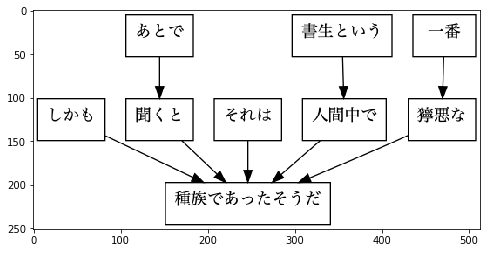

In [15]:
G = make_dependency_graph(neko_chunks[5])
print(G)
G.render('../data/dependency')
img = Image.open('../data/dependency.png')
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()

## 45. 動詞の格パターンの抽出

In [16]:
def get_case_pattern(sentence_chunks):
    verb_to_cases = {}
    for c in sentence_chunks:
        dst_num = c['dst']
        if dst_num == -1:
            continue
        
        dst_chunk = sentence_chunks[dst_num]
        verb_morphs = dst_chunk.search_kv(('pos', '動詞'))
        case_morphs = c.search_kv(('pos', '助詞'))
        
        if case_morphs and verb_morphs:
            c = case_morphs[-1]['base']
            v = verb_morphs[0]['base']
            if v in verb_to_cases.keys():
                verb_to_cases[v].append(c)
            else:
                verb_to_cases[v] = [c]
    
    return verb_to_cases

In [17]:
v2cs = get_case_pattern(neko_chunks[4])
for k, v in v2cs.items():
    print(k + '\t' + ' '.join(v))
    print("="*30)

見る	は を
始める	で


## 46. 動詞の格フレーム情報の抽出

In [18]:
def get_case_frames(sentence_chunks):
    verb_to_cases = {}
    for c in sentence_chunks:
        dst_num = c['dst']
        if dst_num == -1:
            continue
        
        dst_chunk = sentence_chunks[dst_num]
        verb_morphs = dst_chunk.search_kv(('pos', '動詞'))
        case_morphs = c.search_kv(('pos', '助詞'))
        
        if case_morphs and verb_morphs:
            case = case_morphs[-1]['base']
            verb = verb_morphs[0]['base']
            
            particle_phrase = c.get_text(ignore_kv=('pos', '記号'))
            case_frame = (case, particle_phrase)

            if verb in verb_to_cases.keys():
                verb_to_cases[verb].append(case_frame)
            else:
                verb_to_cases[verb] = [case_frame]
    
    return verb_to_cases

In [19]:
v2cs = get_case_frames(neko_chunks[4])
for k, v in v2cs.items():
    v_case = ' '.join([tup[0] for tup in v])
    v_phrase = ' '.join([tup[1] for tup in v])
    output = k + '\t' + v_case + '\t' + v_phrase
    print(output)

見る	は を	吾輩は ものを
始める	で	ここで


## 47. 機能動詞構文のマイニング

In [20]:
def mine_functional_verbs(sentence_chunks):
    verb_to_cases = {}
    # search [noun + `を`] -> [verb]
    for i, p_chunk in enumerate(sentence_chunks):
        dst_num = p_chunk['dst']
        if dst_num == -1:
            continue
        
        dst_chunk = sentence_chunks[dst_num]
        verbs_in_dst = dst_chunk.search_kv(('pos', '動詞'))
        
        # search `助詞` and `を`
        particle_ids = p_chunk.search_kv(('pos', '助詞'), get_id=True)
        if particle_ids is None or verbs_in_dst is None:
            continue
        
        p_id = particle_ids[-1]
        particle = p_chunk.get_idx(p_id)
        if p_id == 0 or particle['surface'] != 'を':
            continue
        
        # search `名詞` and `サ変接続`
        pre_particle = p_chunk.get_idx(p_id-1)
        if pre_particle['pos'] != '名詞'\
        or pre_particle['pos1'] != 'サ変接続':
            continue
        
        # make output shape
        src_case_and_phrase = [
            (sentence_chunks[s].get_text(ignore_kv=('pos', '記号')),
             sentence_chunks[s].search_kv(('pos', '助詞'))[-1]['surface'])
            for s in dst_chunk['srcs']
            if (s != i) and sentence_chunks[s].search_kv(('pos', '助詞'))
        ]
        v_text = pre_particle['surface']\
               + particle['surface']\
               + verbs_in_dst[0]['base']
        
        if len(src_case_and_phrase) == 0:
            continue
        
        if v_text in verb_to_cases.keys():
            verb_to_cases[v_text] += src_case_and_phrase
        else:
            verb_to_cases[v_text] = src_case_and_phrase
            
    return verb_to_cases

In [21]:
for i in range(800, 900):
    v2cs = mine_functional_verbs(neko_chunks[i])
    if len(v2cs) != 0:
        print(v2cs)

{'尽力を仰ぐ': [('やるつもりなので', 'ので'), ('ためで', 'で'), ('先生にも', 'も')]}
{'捺印を願う': [('これへ', 'へ')]}
{'御馳走を致す': [('東風子に', 'に')]}
{'返事をする': [('及ばんさと', 'と'), ('主人は', 'は'), ('手紙に', 'に')]}
{'著述を居る': [('依て', 'て'), ('此間中より', 'より')]}
{'厚遇を受ける': [('猫が', 'が'), ('かくまで', 'まで')]}
{'返事をする': [('下女は', 'は')]}
{'含嗽をやる': [('毎朝風呂場で', 'で')]}


## 48. 名詞から根へのパスの抽出

In [22]:
ARROW = ' -> '
def get_path_to_root(sentence_chunks, kv=('pos', '名詞')):
    path_to_roots = []
    for c in sentence_chunks:
        path_to_root = [c.get_text(ignore_kv=('pos', '記号'))]
        if c.search_kv(kv) is None:
            continue
        
        dst_num = c['dst']
        while dst_num != -1:
            dst_chunk = sentence_chunks[dst_num]
            path_to_root.append(
                sentence_chunks[dst_num].get_text(ignore_kv=('pos', '記号'))
            )
            dst_num = dst_chunk['dst']
        
        path_to_roots.append(path_to_root)
    return path_to_roots

In [23]:
p2rs = get_path_to_root(neko_chunks[4])
for p2r in p2rs:
    print(ARROW.join(p2r))

吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た


## 49. 名詞間の係り受けパスの抽出

In [24]:
import itertools

In [25]:
ARROW = ' -> '
WALL = ' | '
def replace_morph(chunk, kv, repl):
    k, v = kv
    num_of_match = len(chunk.search_kv(kv))
    if num_of_match == 1:
        return ''.join([
            m['surface']
            if m[k]!=v else repl
            for m in chunk.morphs
        ])
    else:
        replaced = []
        match_count = 1
        for m in chunk.morphs:
            if m[k] != v:
                replaced.append(m['surface'])
            else:
                if match_count == num_of_match:
                    replaced.append(repl)
                else:
                    replaced.append(m['surface'])
                    match_count += 1
    return ''.join(replaced)

    
def get_noun_dependencies(sentence_chunks, kv=('pos', '名詞')):
    noun_chunk_ids = []
    id_to_path = {}
    for i, c in enumerate(sentence_chunks):
        if c.search_kv(kv):
            noun_chunk_ids.append(i)
        
        path_to_root = [i]
        dst_num = c['dst']
        while dst_num != -1:
            path_to_root.append(dst_num)
            dst_num = sentence_chunks[dst_num]['dst']
        
        id_to_path[i] = path_to_root
    
    noun_id_pairs = list(itertools.combinations(noun_chunk_ids, 2))
    
    between_paths = []
    for pair in noun_id_pairs:
        X, Y = pair[0], pair[1]
        X_path = id_to_path[X]
        Y_path = id_to_path[Y]
        X_replaced = replace_morph(sentence_chunks[X], ('pos', '名詞'), 'X')
        Y_replaced = replace_morph(sentence_chunks[Y], ('pos', '名詞'), 'Y')
        
        if Y in X_path:
            between_path = X_path[1:X_path.index(Y)]
            between_path = [
                sentence_chunks[idx].get_text() for idx in between_path
            ]
            between_path = ARROW.join([X_replaced]+between_path+[Y_replaced])
            between_paths.append(between_path)
        else:
            XY_junction = set(X_path[1:])&set(Y_path[1:])
            XY_junction = min(list(XY_junction))
            XY_junction_text = sentence_chunks[XY_junction].get_text()
            
            X_to_k = X_path[1:X_path.index(XY_junction)]
            Y_to_k = Y_path[1:Y_path.index(XY_junction)]
            
            X_path_text = [X_replaced] + [
                sentence_chunks[idx].get_text() for idx in X_to_k
            ]
            X_path_text = ARROW.join(X_path_text)
            Y_path_text = [Y_replaced] + [
                sentence_chunks[idx].get_text() for idx in Y_to_k
            ]
            Y_path_text = ARROW.join(Y_path_text)
            between_path = WALL.join([
                X_path_text, Y_path_text, XY_junction_text
            ])
            between_paths.append(between_path)
    
    return between_paths

In [26]:
noun_dependencies = get_noun_dependencies(neko_chunks[4])
for dep in noun_dependencies:
    print(dep)

Xは | Yで -> 始めて -> 人間という -> ものを | 見た。
Xは | Yという -> ものを | 見た。
Xは | Yを | 見た。
Xで -> 始めて -> Yという
Xで -> 始めて -> 人間という -> Yを
Xという -> Yを
